In [19]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any

from agents_nodes.clear_valid_input_validator.input_validator import validate_first_input, validate_input_text_only
from vision_models.input_image_classification.image_classifier import classify_image
from vision_models.ocr import extract_text


In [20]:
class AgentState(TypedDict):
    input_text: str
    attatchments: Dict[str, Any] # dict, each with {user naming for that attachment, the attachment path}

In [21]:
def first_input_validation_node(state: AgentState):
    input_text = state["input_text"]
    attachments = list(state["attatchments"].keys())

    first_input_validation_result = validate_first_input(input_text, attachments)
    state["input_validation_result"] = first_input_validation_result
    state["coming_from_validation"] = "first_input_text"

    return state

In [22]:
def second_input_validation_node(state: AgentState): # validate extracted text from images or attachments
    coming_from_validation = state["coming_from_extracted_text"]

    if coming_from_validation == "images":
        full_input_text = state["extracted_text_from_images"]
    elif coming_from_validation == "attachments":
        full_input_text = state["extracted_text_from_attachments"]

    full_validation_results = []

    for input_text in full_input_text:
        # result[0] = title
        # result[1] = extracted_text
        
        title = input_text[0]
        extracted_text = input_text[1]

        one_validation_results = validate_input_text_only(title, extracted_text)
        full_validation_results.append(one_validation_results)
    if state["extracted_text_from_images_or_attachments_validation_results"] == None:
        state["extracted_text_from_images_or_attachments_validation_results"] = full_validation_results
    else:
        state["extracted_text_from_images_or_attachments_validation_results"].extend(full_validation_results)

    return state

In [23]:
def input_not_valid_fallback_node(state: AgentState):
    validation_results = state["input_validation_result"]

    if state["coming_from_validation"] == "first_input_text":

        if validation_results == "TEXT_VALID_ATTACHMENT_NOT_VALID":
            pass
        elif validation_results == "TEXT_NOT_VALID_ATTACHMENT_VALID":
            pass
        elif validation_results == "TEXT_NOT_VALID_ATTACHMENT_NOT_VALID":
            pass
    
    elif state["coming_from_validation"] == "second_input_text":
        pass # TODO will be implemented later (Not a valid extracted text)

    elif state["coming_from_validation"] == "input_image":
        pass # TODO will be implemented later (Not a valid image)
    
    return state

In [24]:
def input_image_classification_node(state: AgentState):
    input_images_titles_and_paths = state["input_images_titles_and_paths"] # should be a dictionarie with 'title' key and 'path' value for each item

    results = [] # a list of lists, each list have [title, path, classification]
    for title, path in input_images_titles_and_paths.items():
        classification = classify_image(title, path)

        results.append([title, path, classification])
    
    state["input_images_classification_results"] = results

    return state

In [25]:
def extract_text_from_images_node(state: AgentState):
    full_images_results = state["text_images"]
    full_extracted_text = []

    for image_result in full_images_results:
        
        # image_result[0] = title
        # image_result[1] = path
        # image_result[2] = classification
        title = image_result[0]
        path = image_result[1]

        extracted_text = extract_text(path)

        full_extracted_text.append([title, extracted_text])
        # result[0] = title
        # result[1] = extracted_text

    state["extracted_text_from_images_or_attachments"] = full_extracted_text
    state["coming_from_extracted_text"] = "images"
    return state

In [26]:
def input_image_classification_route(state: AgentState):
    full_images_results = state["input_images_classification_results"]
    medical_images = []
    text_images = []

    for image_result in full_images_results:

        # image_result[0] = title
        # image_result[1] = path
        # image_result[2] = classification

        if image_result[2] == "text":
            text_images.append(image_result) # for The extract text from image node

        elif image_result[2] == "not_valid_image":
            state["coming_from_validation"] = "input_image"
            return ["input_not_valid_fallback_node"]
        
        else: # medical images
            medical_images.append(image_result)
    
    nodes_to_return = []
    if text_images:
        state["text_images"] = text_images
        nodes_to_return.append("extract_text_from_images_node")
    
    if medical_images:
        state["medical_images"] = medical_images
        nodes_to_return.append("") # TODO the Agent that uses the medical vision models (just the node name here)

    


    return nodes_to_return    # TODO should be able to call 2 nodes (the medical vision models node and the extract text from image node)


In [27]:
def input_splitter_route(state: AgentState):
    if state["input_validation_result"] != "TEXT_VALID_ATTACHMENT_VALID":
        return "input_not_valid_fallback_node"

    text_provided = True if state['input_text'] else False

    attachments_files = {}
    attachments_images = {}

    for key, value in state['attatchments'].items():
        if value.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            attachments_images[key] = value
        else:
            attachments_files[key] = value


    if text_provided and attachments_files and attachments_images:
        return ["extract_text_from_files_node", "input_image_classification_node"] # TODO will fix the names later

    if text_provided and attachments_files and not attachments_images:
        return "extract_text_from_files_node" # TODO will fix the names later
    
    if text_provided and not attachments_files and attachments_images:
        return ["numerical_models_agent_node", "input_image_classification_node"] # TODO will fix the names later

    if text_provided and not attachments_files and not attachments_images:
        return "numerical_models_agent_node" # TODO will fix the names later

    if not text_provided and attachments_files and attachments_images:
        return ["extract_text_from_files_node", "input_image_classification_node"] # TODO will fix the names later
    
    if not text_provided and attachments_files and not attachments_images:
        return "extract_text_from_files_node" # TODO will fix the names later
    
    if not text_provided and not attachments_files and attachments_images:
        return "input_image_classification_node"
    



In [28]:
def second_input_validation_route(state: AgentState):

    # TODO This route should wait for the ouptut validation of the attachments and the images

    full_validation_results = state["extracted_text_from_images_or_attachments_validation_results"]
    
    for validation_result in full_validation_results:

        if validation_result != "TEXT_VALID":
            state["coming_from_validation"] == "second_input_text"
            return "input_not_valid_fallback_node"

    return "" # TODO the Agent that uses numerical based models (just the node name here)


In [29]:
workflow = StateGraph(AgentState)
workflow.add_node("first_input_validation_node", first_input_validation_node)
workflow.add_node("input_not_valid_fallback_node", input_not_valid_fallback_node)
workflow.add_node("input_image_classification_node", input_image_classification_node)
workflow.add_node("second_input_validation_node", second_input_validation_node)
workflow.add_node("extract_text_from_images_node", extract_text_from_images_node)

workflow.add_edge("extract_text_from_images_node", "second_input_validation_node")

workflow.add_conditional_edges("first_input_validation_node", input_splitter_route)
workflow.add_conditional_edges("input_image_classification_node", input_image_classification_route)
workflow.add_conditional_edges("second_input_validation_node", second_input_validation_route)


In [30]:
workflow.set_entry_point("first_input_validation_node")
app = workflow.compile()

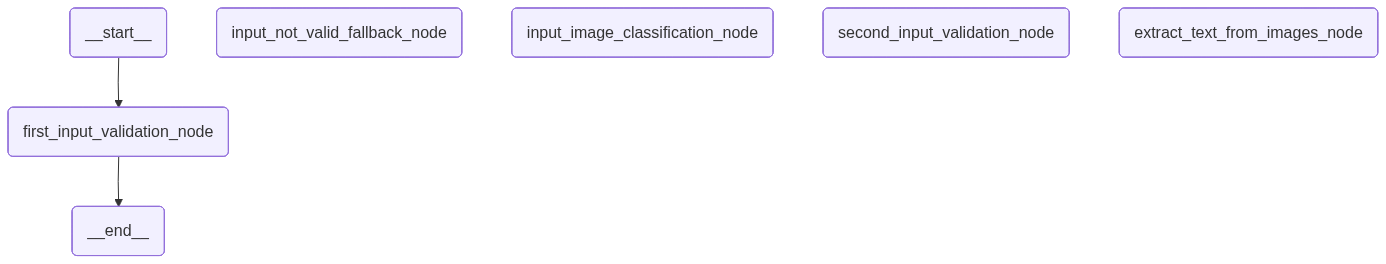

In [31]:
app